# End-of-Test Capacity Analysis

Andrew Weng

1/2/2022

Determine the "state of health" of each cell at the end of their cycle life test.

Focus on parsing the 1C discharge metric. 

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import yaml
from scipy import interpolate
from src.formation import FormationCell

In [2]:
pd.set_option('display.max_rows', 500)

paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Avenir'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)
GREY = (0.9, 0.9, 0.9)

## Load resources

In [4]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


# Inspect data from a single cell

In [19]:
cellid = 1

cell = FormationCell(cellid)
df_cycles = cell.get_aging_data_cycles()

cycle_numbers = df_cycles['Cycle Number'].values

colors = plt.cm.coolwarm(np.linspace(0, 1, len(cycle_numbers) + 1))

plot_frequency = 5

q0_full_ah = 2.37

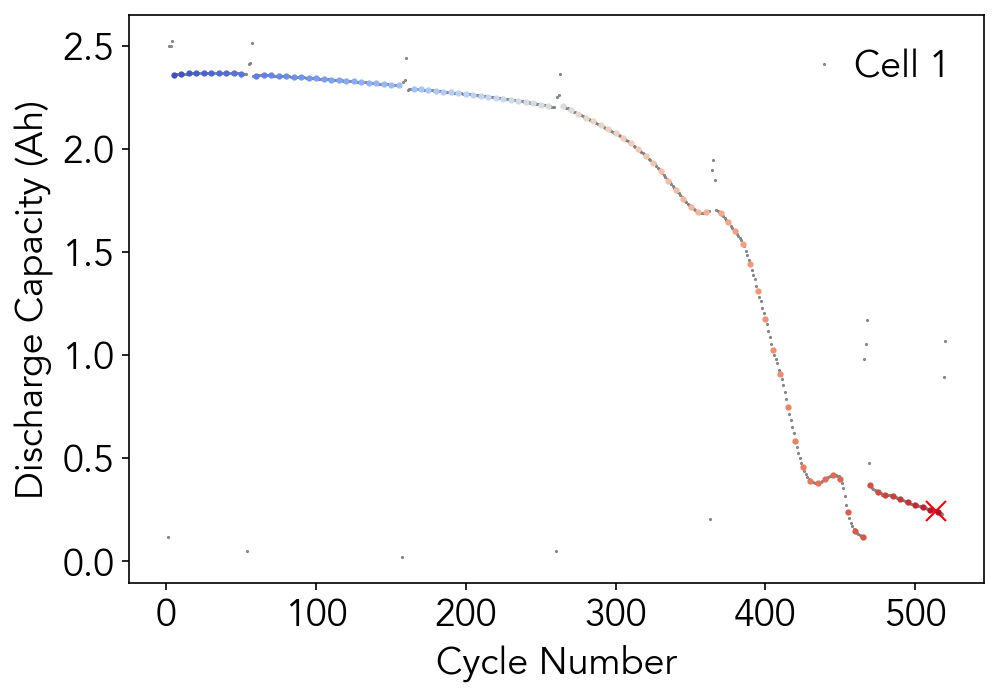

In [20]:
x = df_cycles['Cycle Number']
y = df_cycles['Discharge Capacity (Ah)']

# Estimate the final discharge capacity
q_last = np.median(y[-10:])
idx_last = min(range(len(y)), key=lambda i: abs(y[i] - q_last))

cyc_last = x[idx_last]

plt.figure()

plt.plot(x, y, marker='o', linestyle='none', markersize=0.5, color=(0.5, 0.5, 0.5))
plt.plot(cyc_last, y[idx_last], marker='x', markersize=10, color='r')

for cyc_number in cycle_numbers:
        
    # Some cycles don't have the step index corresponding to the 1C discharge
    # For example, the RPT steps use different step indices. The code will throw
    # an exception when this happens. Here, we're going to ignore this and move on.
    try:
        df_curve = cell.get_aging_data_discharge_curve(cyc_number)
    except:
        continue
        
    # Don't plot every cycle
    if cyc_number % plot_frequency != 0:
        continue
    
    q_vec = df_curve['Discharge Capacity (Ah)']
    
    # Skip erroneous cycles
    if np.min(q_vec) > 0.05:
        continue
        
    q = np.max(q_vec)
    
    plt.plot(cyc_number, q, marker='o', markersize=2, linestyle='none', color=colors[cyc_number])

plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend([f'Cell {cellid}'], frameon=False, handlelength=0)


<Figure size 1050x750 with 0 Axes>

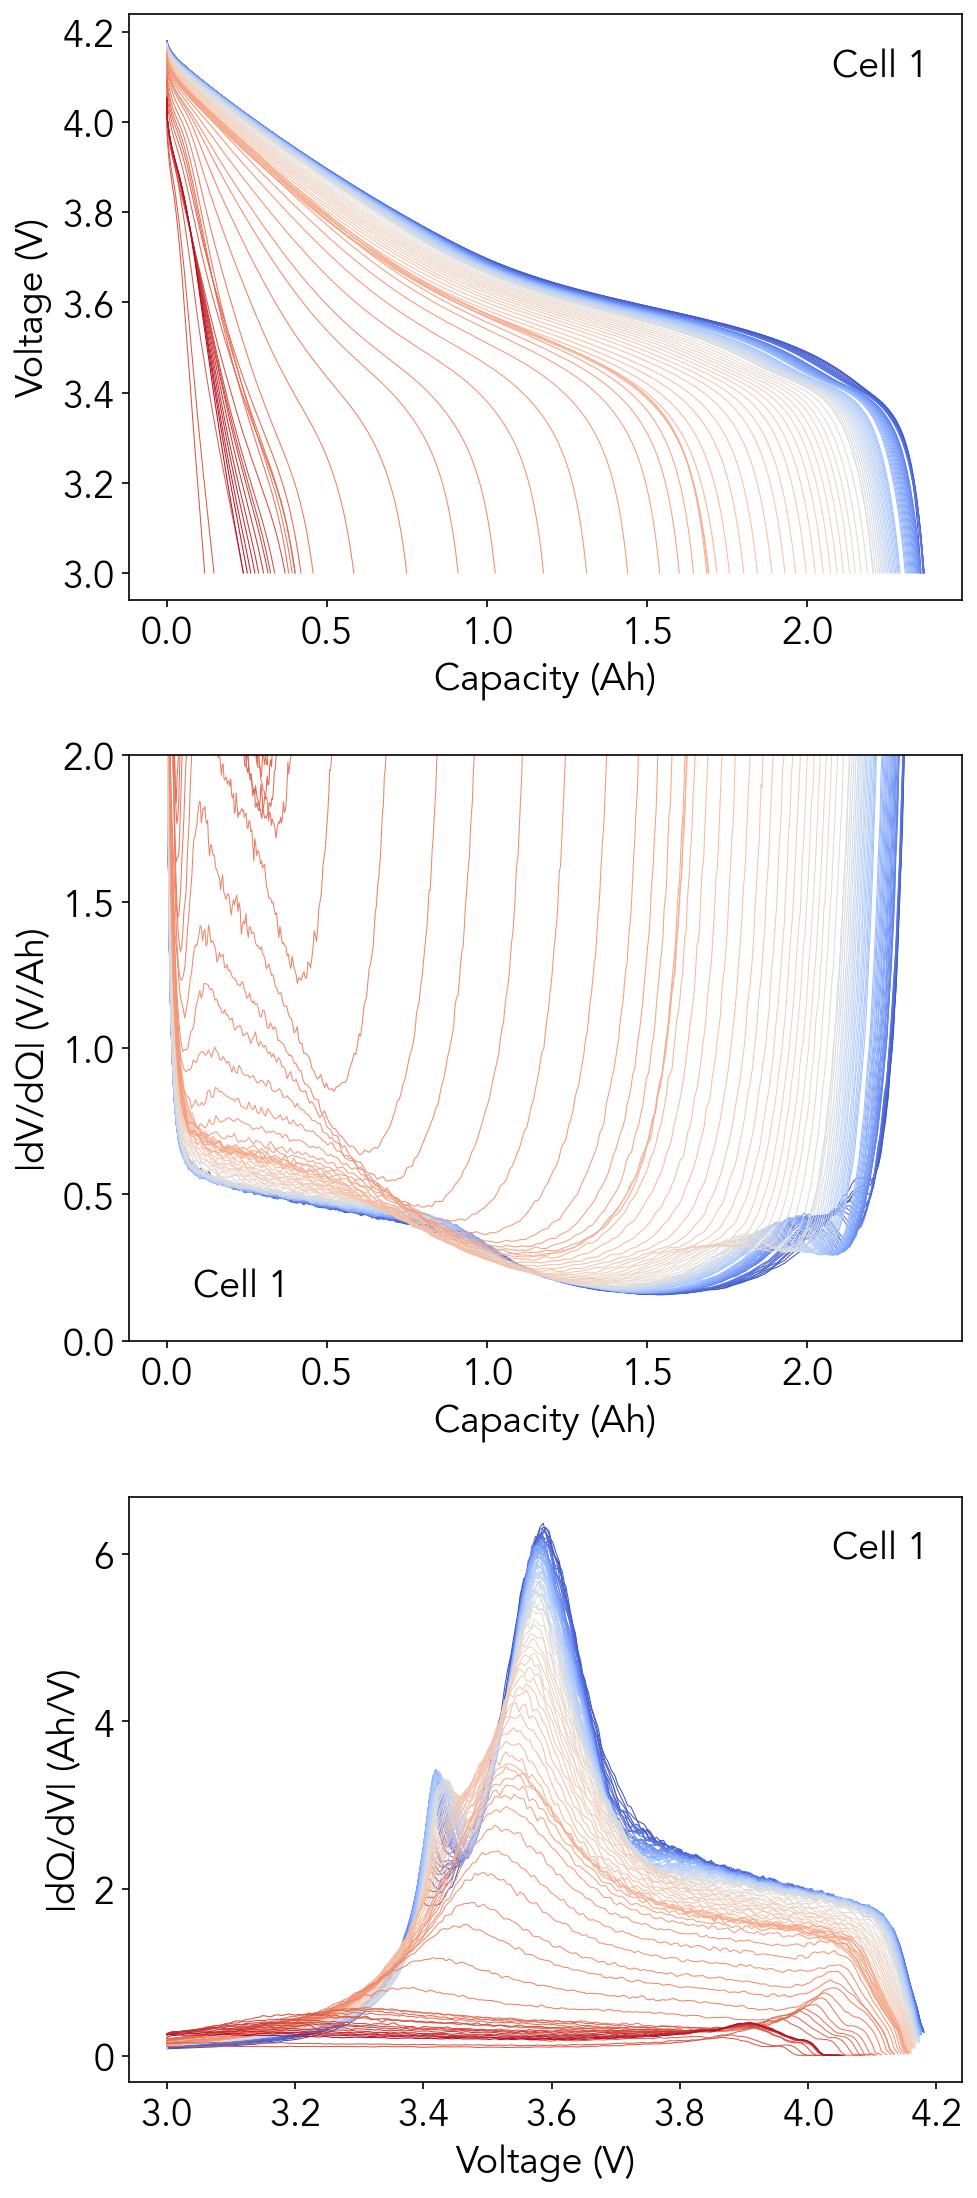

In [21]:

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(7, 15))

for cyc_number in cycle_numbers:
    
    # Some cycles don't have the step index corresponding to the 1C discharge
    # For example, the RPT steps use different step indices. The code will throw
    # an exception when this happens. Here, we're going to ignore this and move on.
    try:
        df_curve = cell.get_aging_data_discharge_curve(cyc_number)
    except:
        continue
        
    # Don't plot every cycle
    if cyc_number % plot_frequency != 0:
        continue

    # Skip erroneous cycles
    if np.min(df_curve['Discharge Capacity (Ah)']) > 0.05:
        continue
    
    q = df_curve['Discharge Capacity (Ah)']
    v = df_curve['Potential (V)']
    dvdq = np.gradient(v) / np.gradient(q)
    dqdv = np.gradient(q) / np.gradient(v)
    
    ax1.plot(q, v,     linewidth=0.5, color=colors[cyc_number])
    ax2.plot(q, -dvdq, linewidth=0.5, color=colors[cyc_number])
    ax3.plot(v, -dqdv, linewidth=0.5, color=colors[cyc_number])
    
ax1.set_xlabel('Capacity (Ah)')
ax1.set_ylabel('Voltage (V)')

ax2.set_xlabel('Capacity (Ah)')
ax2.set_ylabel('|dV/dQ| (V/Ah)')
ax2.set_ylim((0, 2))

ax3.set_xlabel('Voltage (V)')
ax3.set_ylabel('|dQ/dV| (Ah/V)')

ax1.legend([f'Cell {cellid}'], frameon=False, handlelength=0)
ax2.legend([f'Cell {cellid}'], frameon=False, handlelength=0)
ax3.legend([f'Cell {cellid}'], frameon=False, handlelength=0)

# Extract the end-of-test capacity metric from each cell

In [8]:
num_cycles_to_include = 10

res_all = []

for cell in formation_cells:
    
    df_cycles = cell.get_aging_data_cycles()

    x = df_cycles['Cycle Number']
    y = df_cycles['Discharge Capacity (Ah)']

    # Estimate the final discharge capacity
    q_last = np.median(y[-num_cycles_to_include:])
    
    idx_last = min(range(len(y)), key=lambda i: abs(y[i] - q_last))

    # Scalar values
    cyc_last = x[idx_last]
    cap_last = y[idx_last]
    
    # Capacity traces
    df_curve = cell.get_aging_data_discharge_curve(cyc_last)
    q_vec = df_curve['Discharge Capacity (Ah)'].values
    v_vec = df_curve['Potential (V)'].values
    
    df_curve_fresh = cell.get_aging_data_discharge_curve(5)
    q_vec_fresh = df_curve_fresh['Discharge Capacity (Ah)'].values
    v_vec_fresh = df_curve_fresh['Potential (V)'].values
    
    res = dict()
    res['cellid'] = cell.cellid
    res['is_room_temp'] = cell.is_room_temp()
    res['is_baseline_formation'] = cell.is_baseline_formation()
    
    res['cycle_number'] = x
    res['discharge_capacity_ah'] = y
    
    res['thickness_mm'] = cell.get_thickness()
    res['cyc_last'] = cyc_last
    res['cap_last_ah'] = cap_last
    res['q_last_vec'] = q_vec;
    res['v_last_vec'] = v_vec;
    
    f = interpolate.interp1d(v_vec, q_vec, fill_value='extrapolate')
    res['q_last_partial_ah'] = f(3.5) - f(4.0);
    
    f_fresh = interpolate.interp1d(v_vec_fresh, q_vec_fresh, fill_value='extrapolate')
    q0_partial_ah = f_fresh(3.5) - f_fresh(4.0)
    res['soh_partial'] = res['q_last_partial_ah'] / q0_partial_ah * 100;

    res['soh'] = cap_last / np.max(q_vec_fresh) * 100
    
    res_all.append(res)
          
df_res = pd.DataFrame(res_all)

Text(0, 0.5, 'Discharge Capacity (Ah)')

<Figure size 1050x750 with 0 Axes>

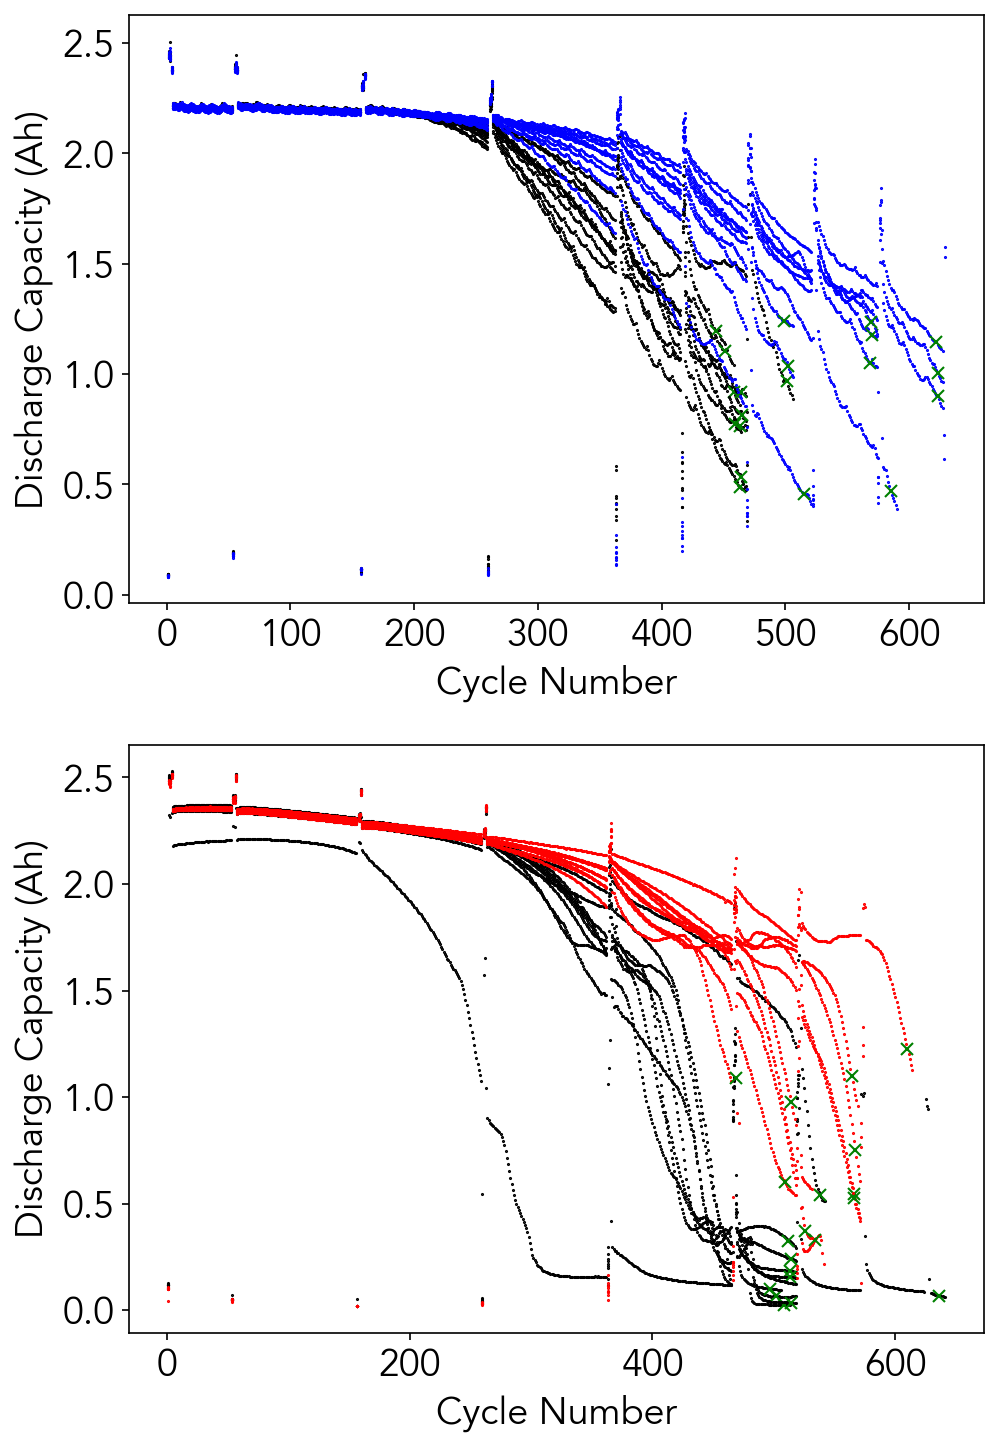

In [9]:
colors = plt.cm.prism(np.linspace(0, 1, len(res_all) + 1))
np.random.shuffle(colors)

plt.figure()

fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 10))

for idx, res in enumerate(res_all):
   
    ax = ax1 if res['is_room_temp'] else ax2
    
    col = 'k'
    if not res['is_baseline_formation']:
        col = 'b' if res['is_room_temp'] else 'r'
        
    ax.plot(res['cycle_number'], res['discharge_capacity_ah'], 
             marker='o', markersize=0.5, linestyle='none', color=col)
    
    ax.plot(res['cyc_last'], res['cap_last_ah'], 
             marker='x', markersize=6, color='g')
    
ax1.set_xlabel('Cycle Number')
ax1.set_ylabel('Discharge Capacity (Ah)')
ax2.set_xlabel('Cycle Number')
ax2.set_ylabel('Discharge Capacity (Ah)')

Text(0, 0.5, 'SOH (%)')

<Figure size 1050x750 with 0 Axes>

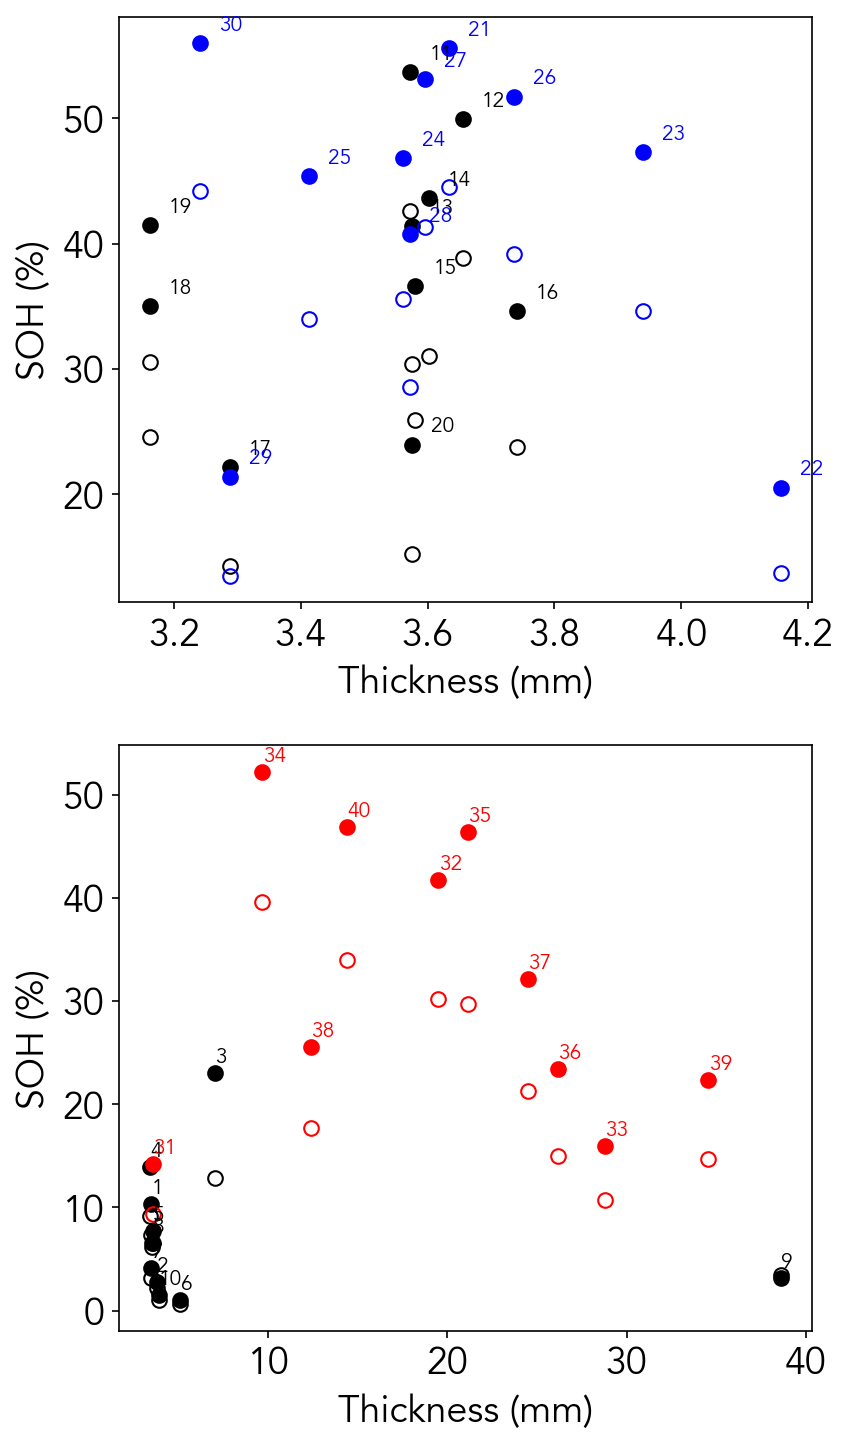

In [10]:
plt.figure()

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

for idx, res in enumerate(res_all):
   
    ax = ax1 if res['is_room_temp'] else ax2
    
    col = 'k'
    if not res['is_baseline_formation']:
        col = 'b' if res['is_room_temp'] else 'r'
        
    ax.plot(res['thickness_mm'], res['soh'], marker='o', markersize=7, linestyle='none', color=col)
    ax.plot(res['thickness_mm'], res['soh_partial'], marker='o', markersize=7, fillstyle='none', linestyle='none', color=col)
    ax.text(res['thickness_mm'] + 0.03, res['soh'] + 1, f'{res["cellid"]}', fontsize=10, color=col)
    
ax1.set_xlabel('Thickness (mm)')
ax1.set_ylabel('SOH (%)')
ax2.set_xlabel('Thickness (mm)')
ax2.set_ylabel('SOH (%)')

# TODO:

- Re-plot SOH but during charging